In [172]:
import pandas as pd
import numpy as np
# import matplotlib.gridspec as gridspec
# import matplotlib.ticker as ticker 
import matplotlib.pyplot as plt
# from scipy.integrate import simps
import spm1d
import os


Titles=['Mean & StdDevs','T-Test', '% Sig Difference']

Colours =[['royalblue','m','r','g','darkorange'],
          ['lightsteelblue','violet','salmon','lightgreen','moccasin']]

E = [['E1','E2','E3','E4','E5','E6','E7'],
     ['Element 1','Element 2','Element 3','Element 4','Element 5','Element 6','Element 7']]
J = [['J1','J2','J3','J4','J5','J6','J7'],
     ['Elbow','Shoulder Abd/Add', 'Shoulder For/Back','Trunk Flex/Ext','Trunk Lat','Hip Flex/Ext', 'Knee Flex/Ext']]
G = [['G1A','G2A','G3A','G4A'], 
     ['Group 1','Group 2','Group 3','Group 4']]


Element=E[0][0]

In [173]:
def Post_Hoc_Analysis(Joint,Joint_String):
    Groups_Dict={}
    OneWay_Dict={}
    TTest_Dict={}
    MaxIndex=0
    Columns=[]
    #########################################################################################
    #                                   1 - DATA SETUP
    #########################################################################################
    for Group in G[0]:
        for entry in os.scandir(r'F:\Final_Curves'):
            filename='{}_{}_{}_JA'.format(Element,Group,Joint)
            if filename in entry.path:

                Raw_Data = pd.read_csv(entry.path, sep='\t')

                #Re-arrange raw data to operate on
                Sample_Set = Raw_Data[Raw_Data.columns[1::2]].reindex(sorted(Raw_Data.columns[1::2]), axis=1)

                if len(Sample_Set.index) > MaxIndex:
                    MaxIndex = len(Sample_Set.index)

                for i in Sample_Set.columns:
                    Columns.append(i)

                Groups_Dict[Group]=Sample_Set


    """ Compute and Create One-Way ANOVA"""                
    OneWay_Dict['Y']=pd.DataFrame(columns=Columns, index=[i for i in range(MaxIndex)])
    OneWay_Dict['A']=[]

    for Index, Group in enumerate(Groups_Dict):
        for i in Groups_Dict[Group].columns:
            OneWay_Dict['Y'][i]=spm1d.util.interp(Groups_Dict[Group][i], Q=MaxIndex)
            OneWay_Dict['A'].append(Index)


    OneWay_Dict['Y'].columns=OneWay_Dict['A']

    OneWay_Dict['Y']=OneWay_Dict['Y'].T.to_numpy()
    OneWay_Dict['A']=np.array(OneWay_Dict['A'])

    #########################################################################################
    #                                       2 - Stats
    #########################################################################################


    alpha        = 0.05
    F            = spm1d.stats.anova1(OneWay_Dict['Y'], OneWay_Dict['A'], equal_var=False)
    Fi           = F.inference(alpha)

    if Fi.h0reject == False:
        print(Fi)
    else:
        for i in Groups_Dict.keys():
            TTest_Dict[i]={}

            TTest_Dict[i][i] = pd.DataFrame(columns=Groups_Dict[i].columns, 
                                            index=[x for x in range(MaxIndex)])

            for x in Groups_Dict[i].columns:
                TTest_Dict[i][i][x]=spm1d.util.interp(Groups_Dict[i][x], Q=MaxIndex)

        for i in Groups_Dict.keys():
            for j in Groups_Dict.keys():
                if i != j:
                    alpha      = 0.05
                    t          = spm1d.stats.ttest2(TTest_Dict[i][i].T,
                                                    TTest_Dict[j][j].T, equal_var=False)
                    ti         = t.inference(alpha, two_tailed=True, interp=True)

                    TTest_Dict[i][j]=ti

        #########################################################################################
        #                                       2 - Plots
        #########################################################################################

        fig, axs = plt.subplots(nrows=len(Groups_Dict),ncols=len(Groups_Dict), figsize=(24, 24))
        fig.suptitle('{} - {}'.format(Element,Joint_String), y=0.94, fontsize=60)

        for i, iv in enumerate(Groups_Dict.keys()):
            for j, jv in enumerate(Groups_Dict.keys()):
                axs[i,j].xaxis.set_visible(False)
                axs[i,j].yaxis.set_visible(False) 

                if j == 0 and i == 0:
                    axs[i,j].yaxis.set_visible(True)
                    axs[i,j].set_title('{}'.format(iv),fontsize=45)
                    axs[i,j].set_ylabel('{}'.format(jv), fontsize=45, labelpad=60, rotation=0)
                    axs[i,j].tick_params(axis='y',          # changes apply to the x-axis
                                         which='both',      # both major and minor ticks are affected
                                         bottom=False,      # ticks along the bottom edge are off
                                         top=False,         # ticks along the top edge are off
                                         labelleft=False) # labels along the bottom edge are off            
                elif i == 0:
                    axs[i,j].set_title('{}'.format(jv),fontsize=45)

                elif j == 0:
                    axs[i,j].yaxis.set_visible(True)
                    axs[i,j].set_ylabel('{}'.format(iv), fontsize=45, labelpad=60, rotation=0)
                    axs[i,j].tick_params(axis='y',          # changes apply to the x-axis
                                         which='both',      # both major and minor ticks are affected
                                         bottom=False,      # ticks along the bottom edge are off
                                         top=False,         # ticks along the top edge are off
                                         labelleft=False) # labels along the bottom edge are off

                if j > i :
                    axs[i,j].spines['bottom'].set_color('w')
                    axs[i,j].spines['top'].set_color('w')
                    axs[i,j].spines['right'].set_color('w')
                    axs[i,j].spines['left'].set_color('w')

#                     if TTest_Dict[iv][jv].h0reject == False:
#                         axs[i,j].set_facecolor('k')        
#                     else:
#                         Alpha = ('\u03B1 = {0:.2f}'.format(TTest_Dict[iv][jv].alpha))
#                         Fstar = ('t = {0:.2f}'.format(TTest_Dict[iv][jv].zstar))
#                         if TTest_Dict[iv][jv].p_set < 0.001:
#                             pStat = ('p < 0.001')
#                         else:
#                             pStat = ('p = {0:.3f}'.format(TTest_Dict[iv][jv].p_set))    

#                         axs[i,j].text(0.1, 0.75, Alpha, ha='left', rotation=0, wrap=True, fontsize=35)
#                         axs[i,j].text(0.1, 0.5, Fstar, ha='left', rotation=0, wrap=True, fontsize=35)
#                         axs[i,j].text(0.1, 0.25, pStat, ha='left', rotation=0, wrap=True, fontsize=35)

                if i < j :
                    if TTest_Dict[iv][jv].h0reject == False:
                        axs[j,i].set_facecolor('k')        
                    else:
                        Alpha = ('\u03B1 = {0:.2f}'.format(TTest_Dict[iv][jv].alpha))
                        Fstar = ('t = {0:.2f}'.format(TTest_Dict[iv][jv].zstar))
                        if TTest_Dict[iv][jv].p_set < 0.001:
                            pStat = ('p < 0.001')
                        else:
                            pStat = ('p = {0:.3f}'.format(TTest_Dict[iv][jv].p_set))    

                        axs[j,i].text(0.1, 0.75, Alpha, ha='left', rotation=0, wrap=True, fontsize=35)
                        axs[j,i].text(0.1, 0.5, Fstar, ha='left', rotation=0, wrap=True, fontsize=35)
                        axs[j,i].text(0.1, 0.25, pStat, ha='left', rotation=0, wrap=True, fontsize=35)

                if i == j :
                    axs[i,j].set_facecolor('grey') 
                    
        fig.savefig('F:\Plots\{}_{}.jpeg'.format(Element,Joint),bbox_inches='tight')

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



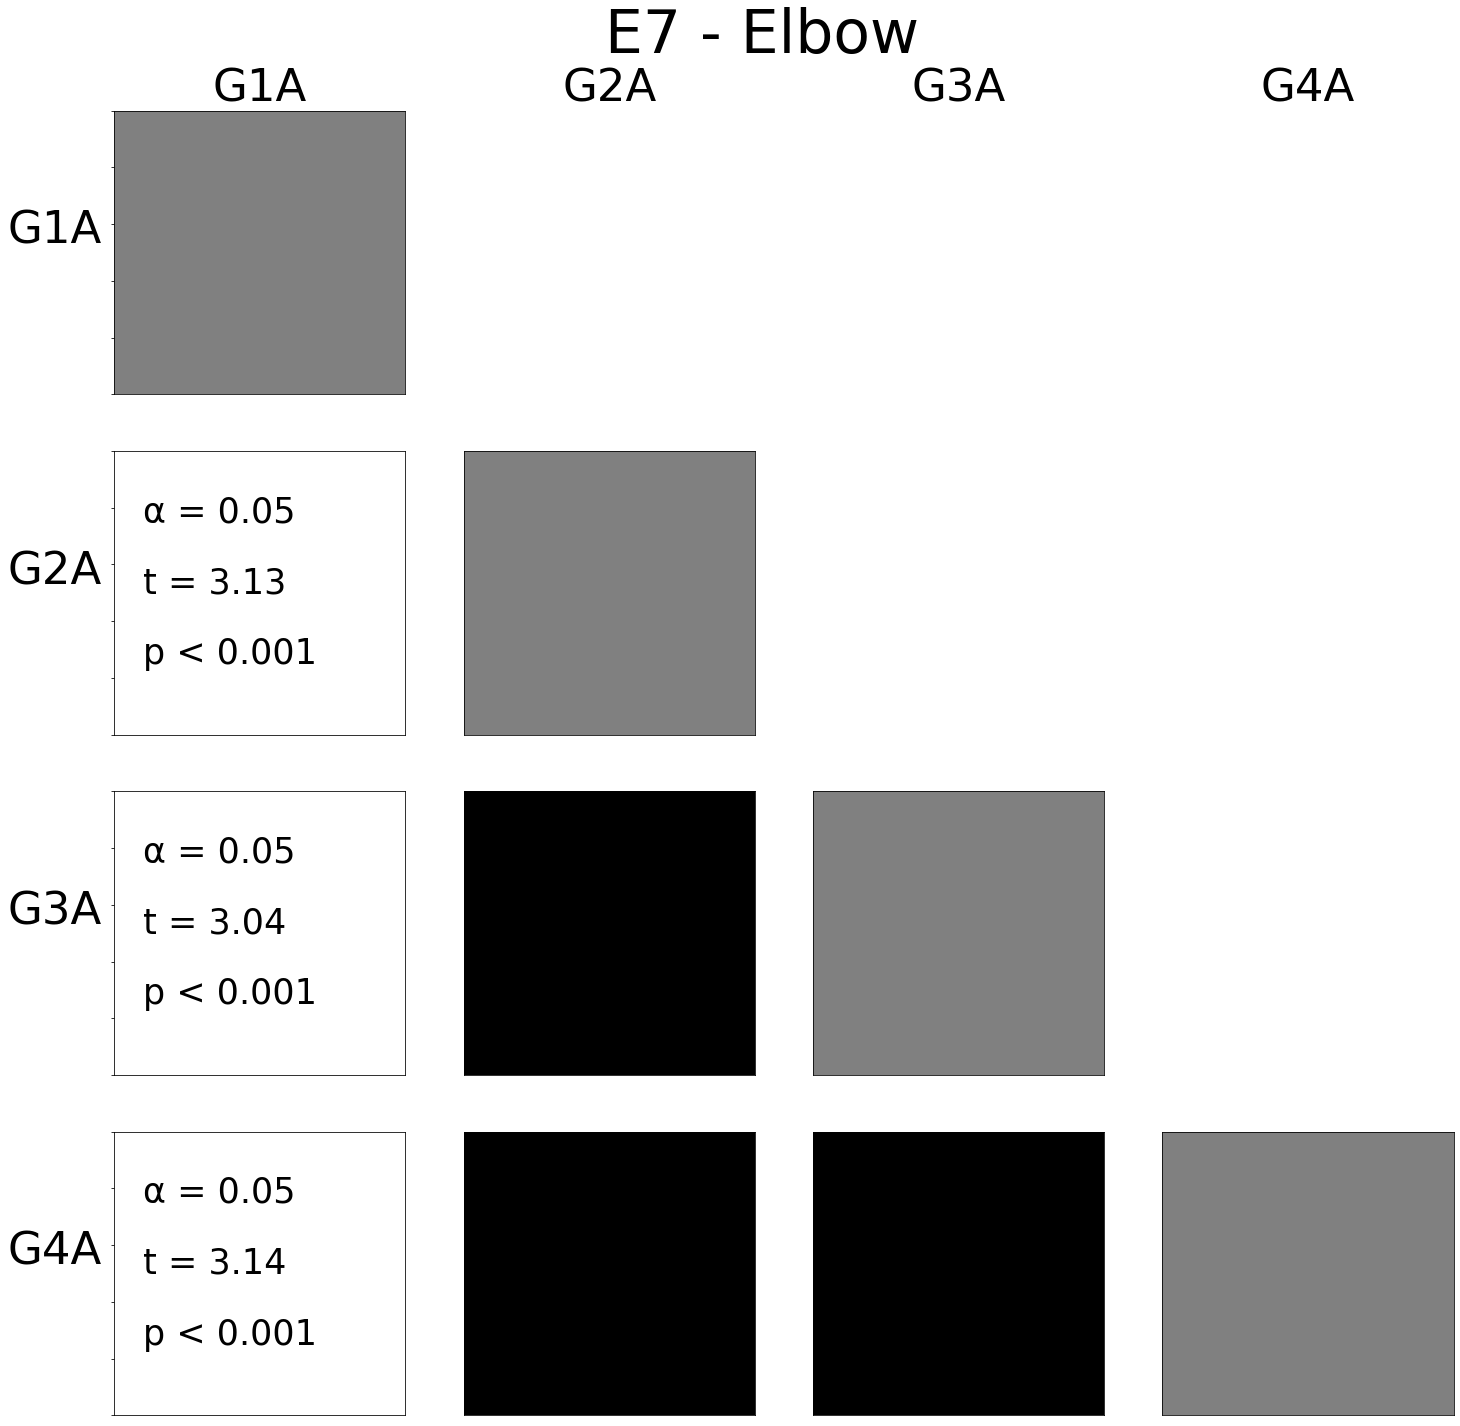

In [174]:
Post_Hoc_Analysis(J[0][0],J[1][0])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



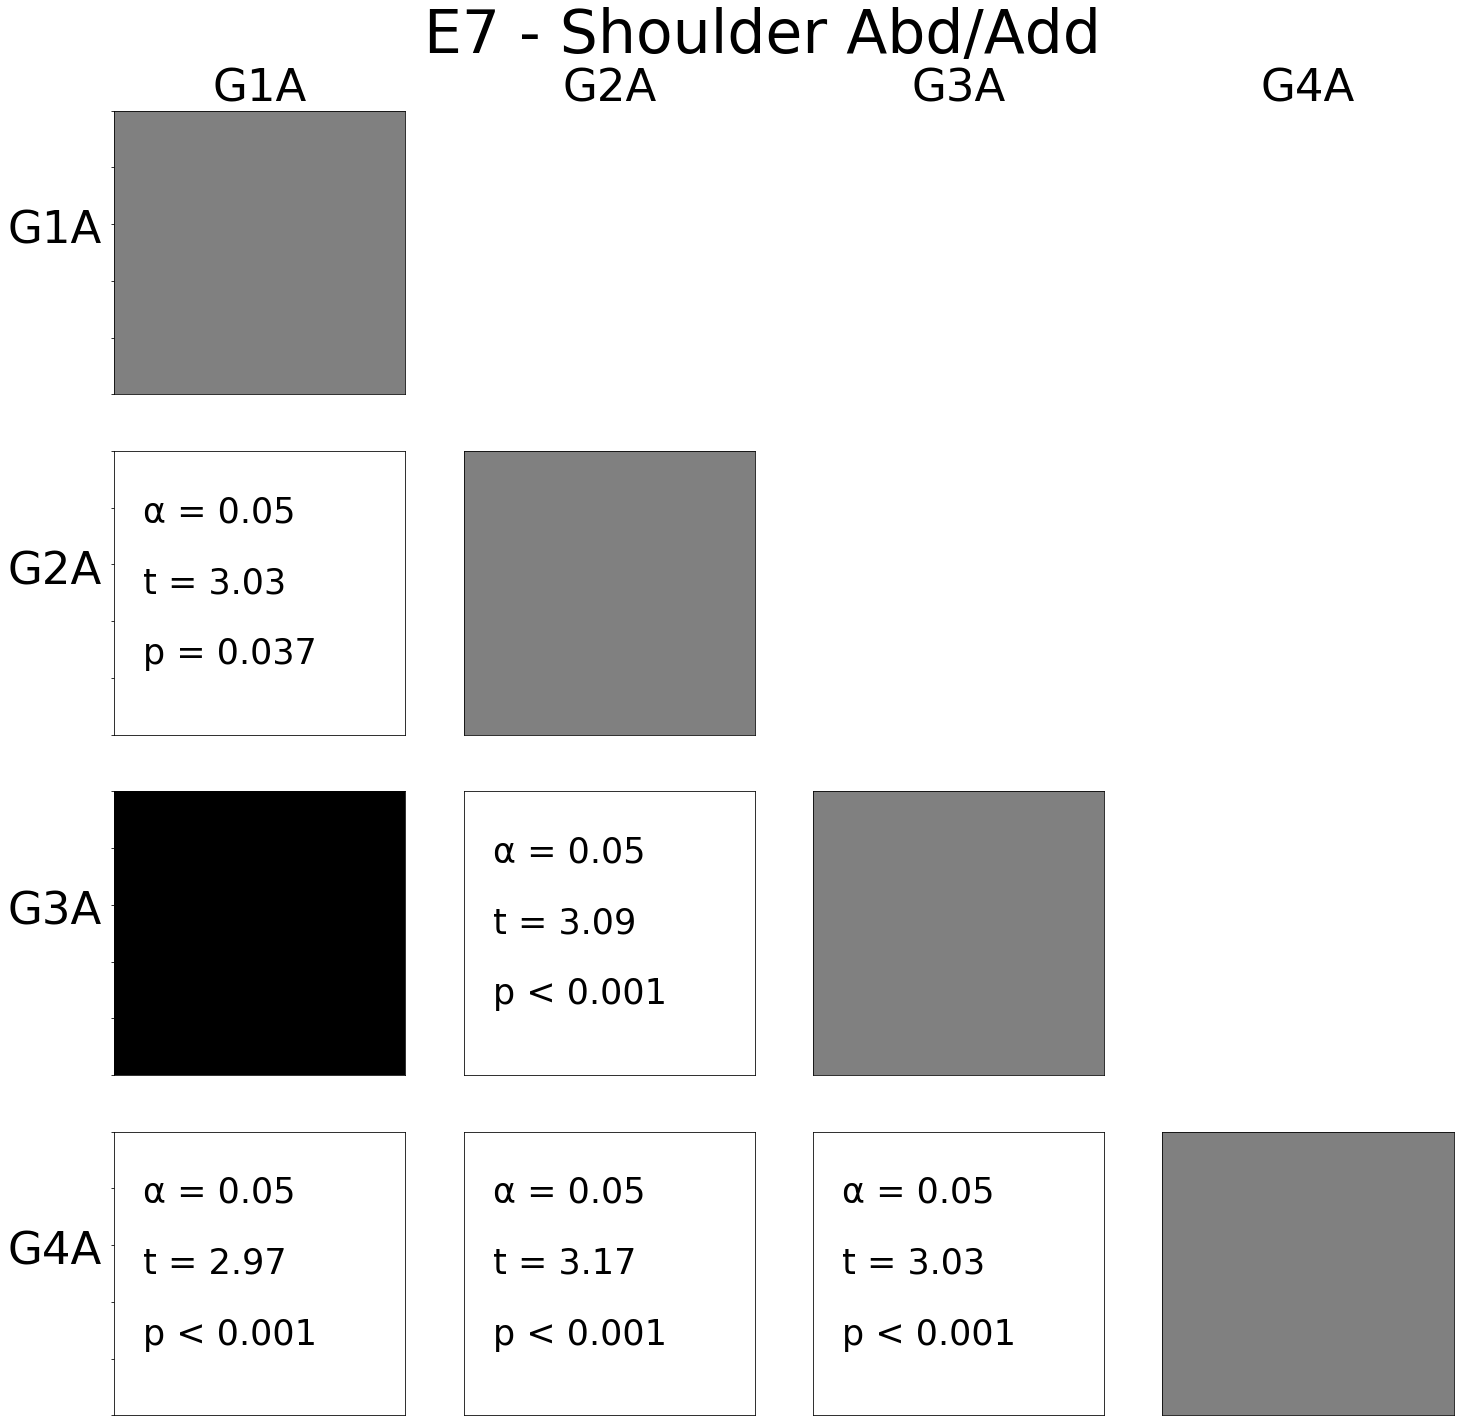

In [175]:
Post_Hoc_Analysis(J[0][1],J[1][1])

In [176]:
Post_Hoc_Analysis(J[0][2],J[1][2])

SPM{F} inference field
   SPM.effect    :   Main A
   SPM.z         :  (1x191) raw test stat field
   SPM.df        :  (1.935, 76.197)
   SPM.fwhm      :  36.55344
   SPM.resels    :  (1, 5.19787)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  6.04992
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



In [177]:
Post_Hoc_Analysis(J[0][3],J[1][3])

SPM{F} inference field
   SPM.effect    :   Main A
   SPM.z         :  (1x179) raw test stat field
   SPM.df        :  (2.000, 78.773)
   SPM.fwhm      :  38.53960
   SPM.resels    :  (1, 4.61863)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  5.79333
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



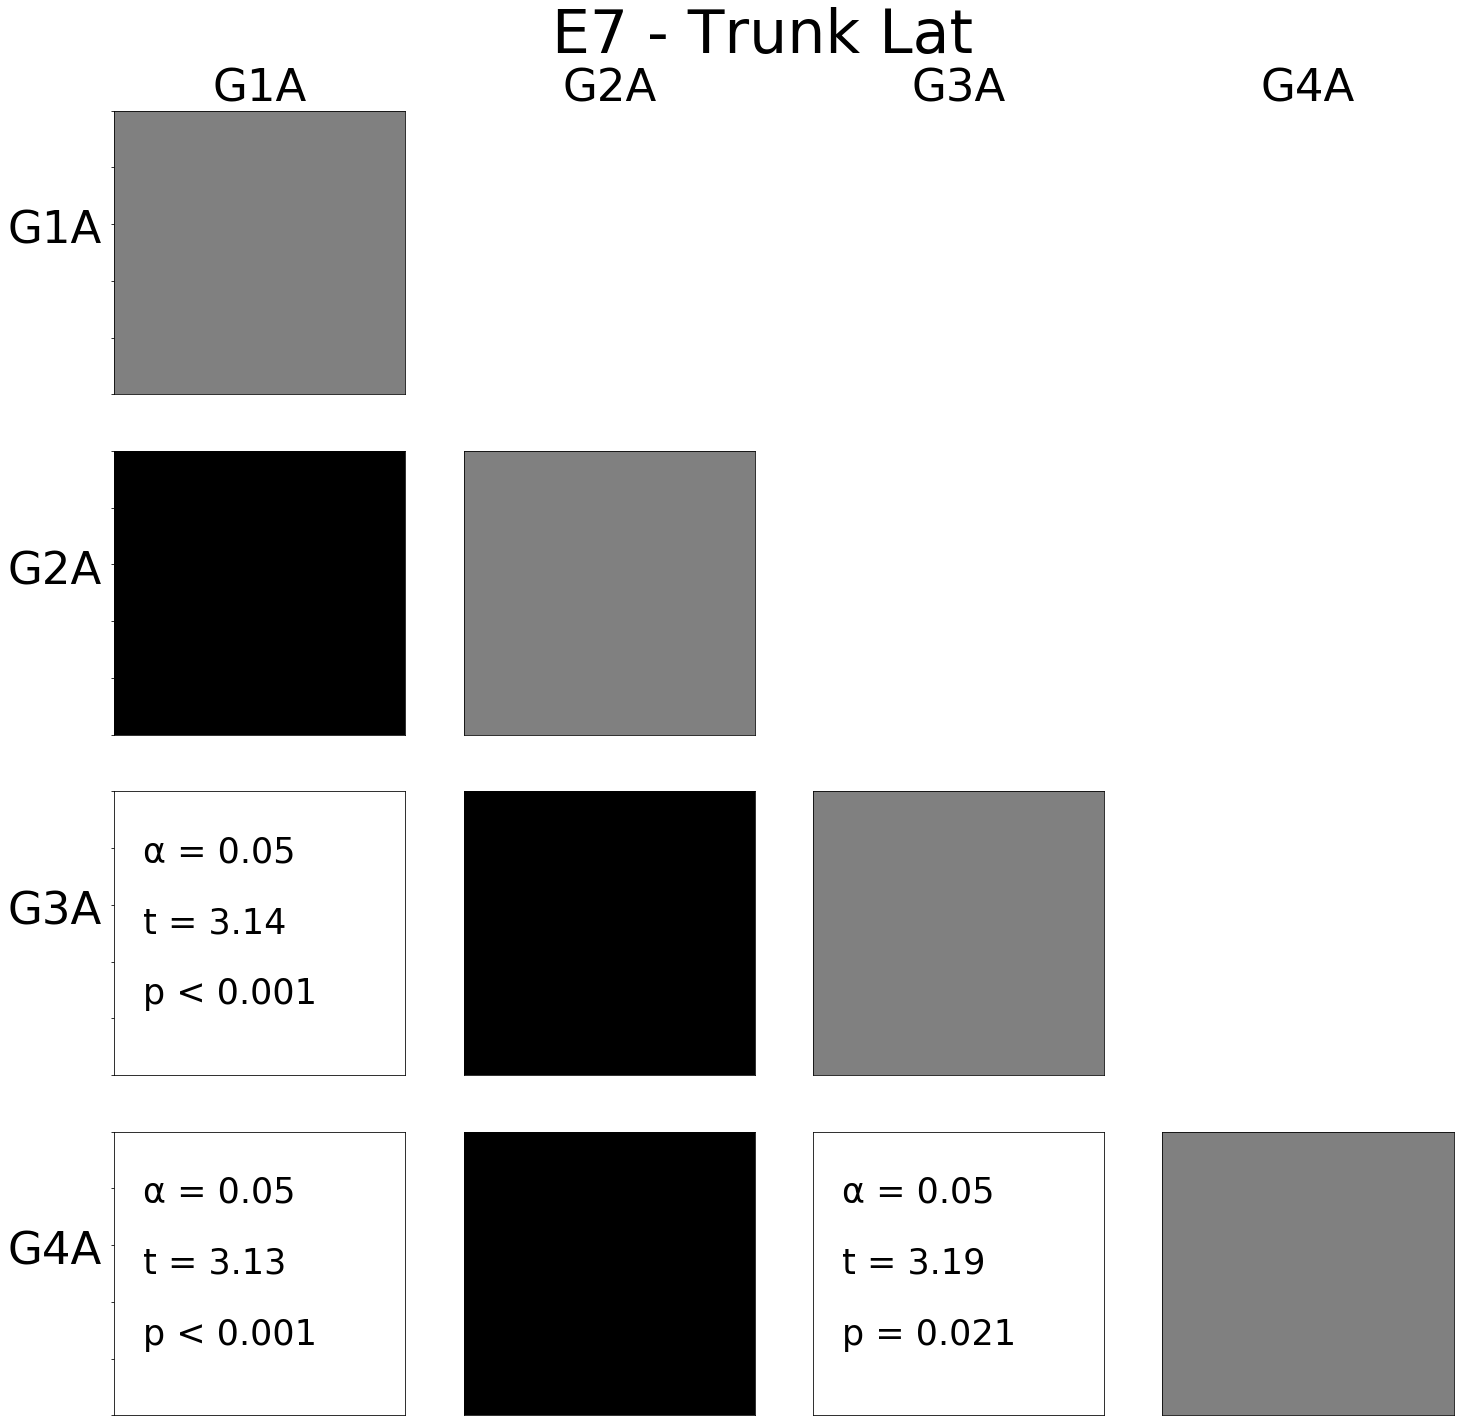

In [178]:
Post_Hoc_Analysis(J[0][4],J[1][4])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



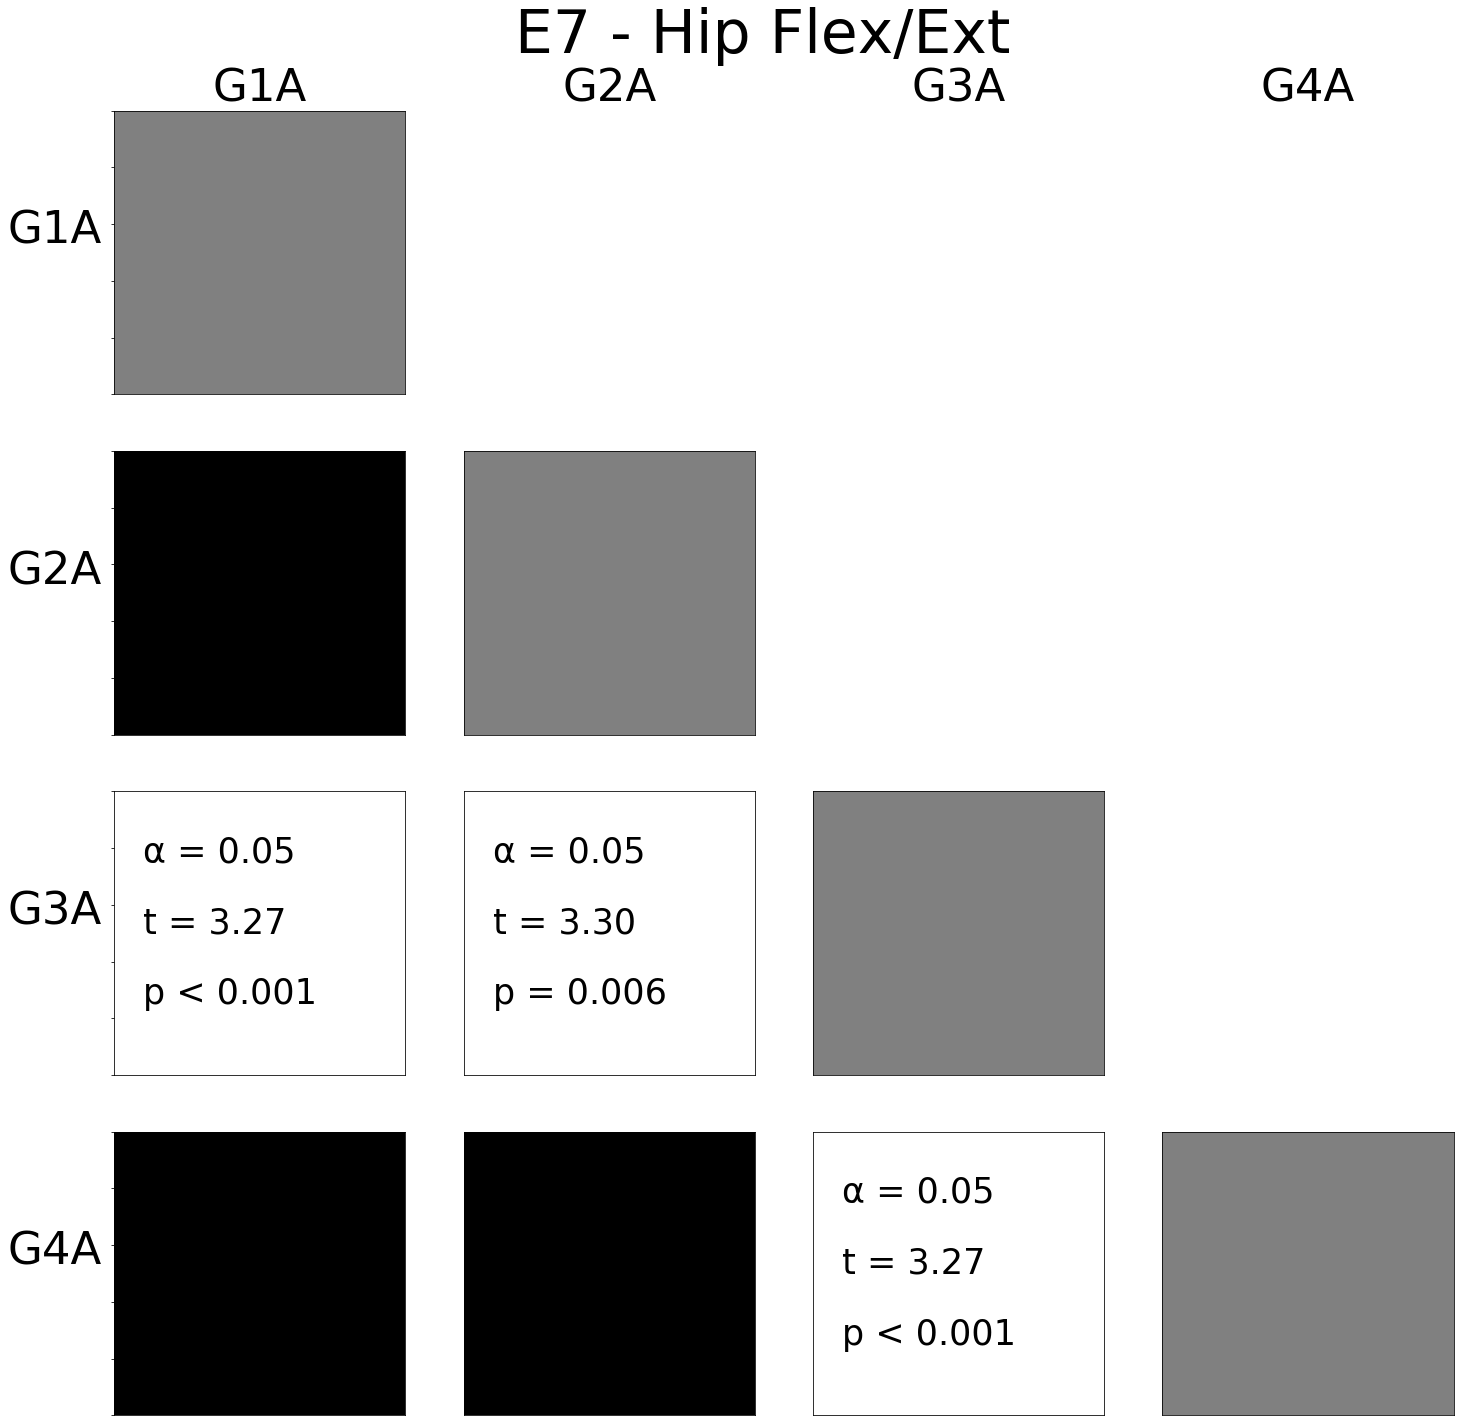

In [179]:
Post_Hoc_Analysis(J[0][5],J[1][5])

C:\Users\KAGUMBA\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 



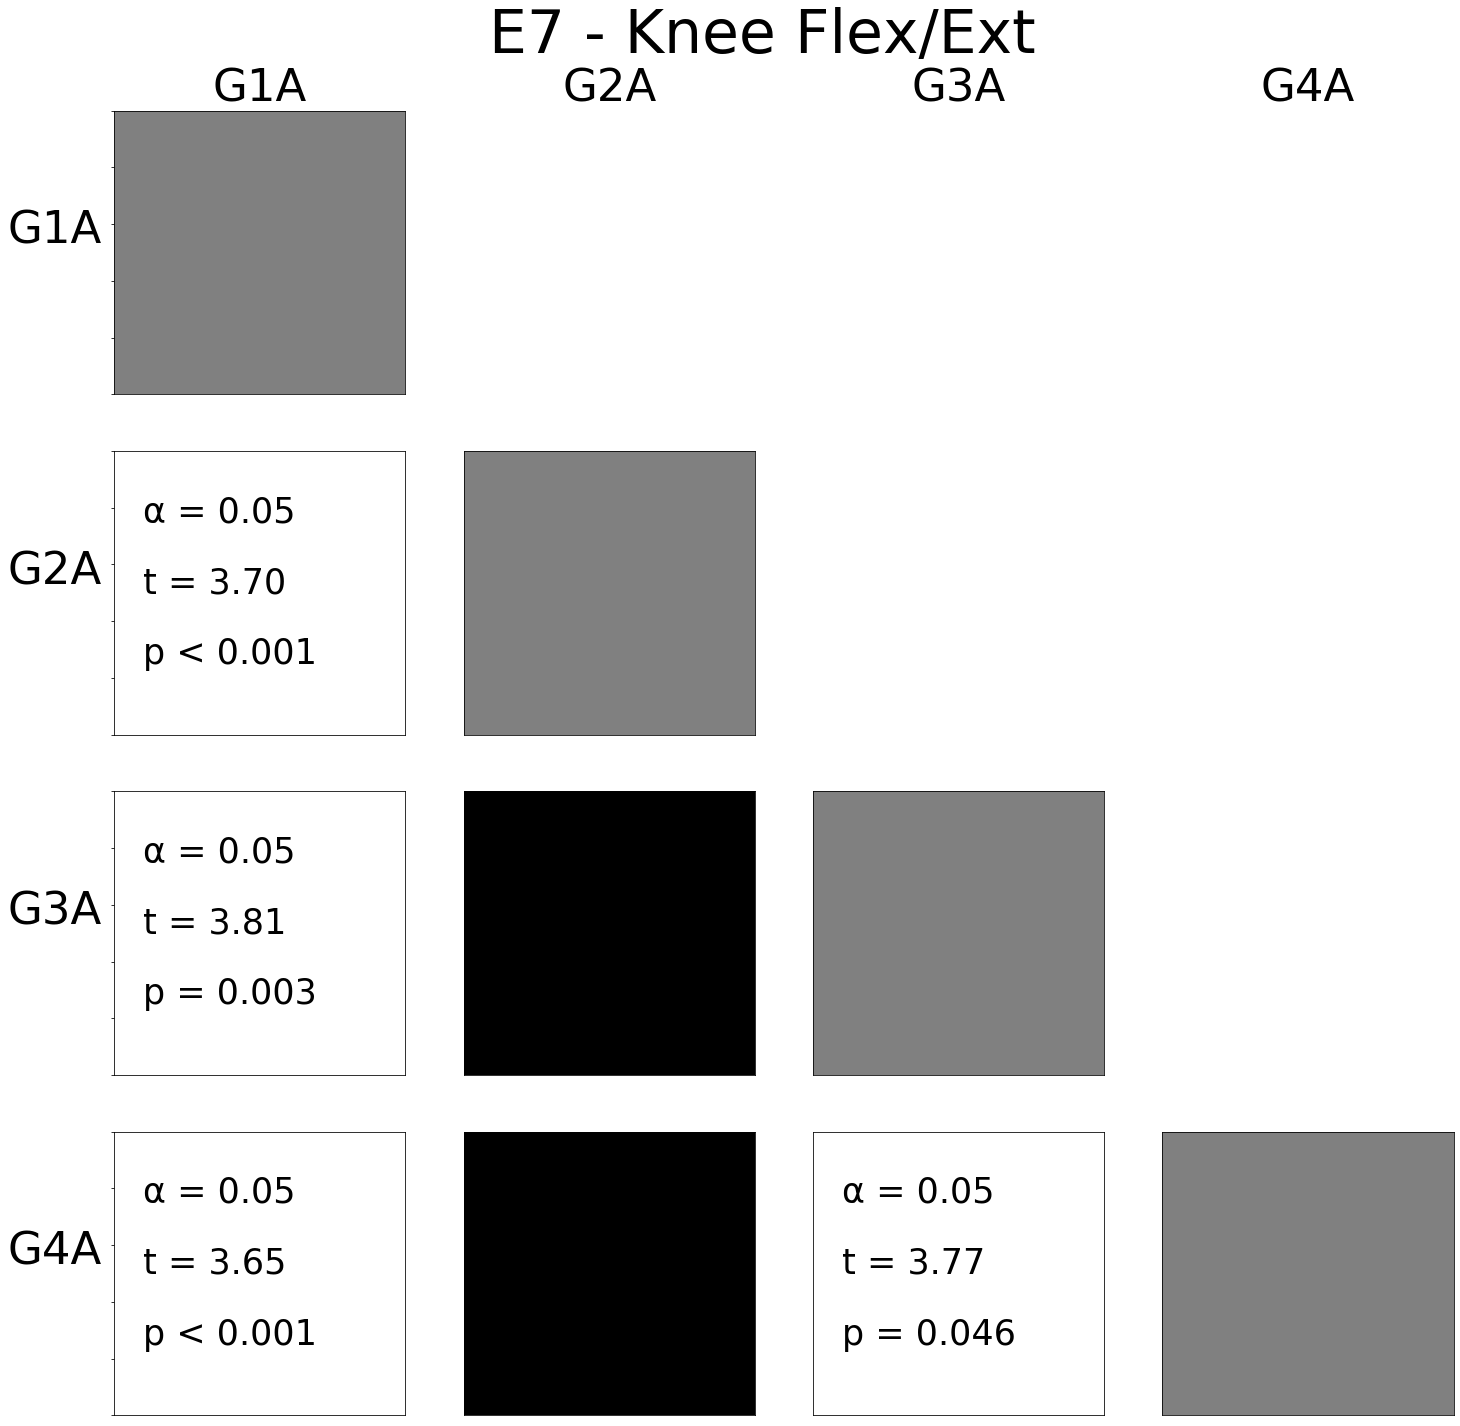

In [180]:
Post_Hoc_Analysis(J[0][6],J[1][6])